# Importing the needed packages for solving this problem.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split


In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [34]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [73]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Test-Train Split:

In [35]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


# Data Exploration

In [36]:
colon_main.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [37]:
colon_main.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [77]:
colon_main.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

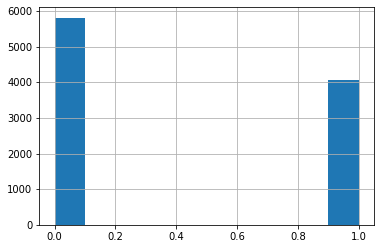

In [78]:
colon_main.isCancerous.hist()
plt.show()

Text(0, 0.5, 'notCancerous samples')

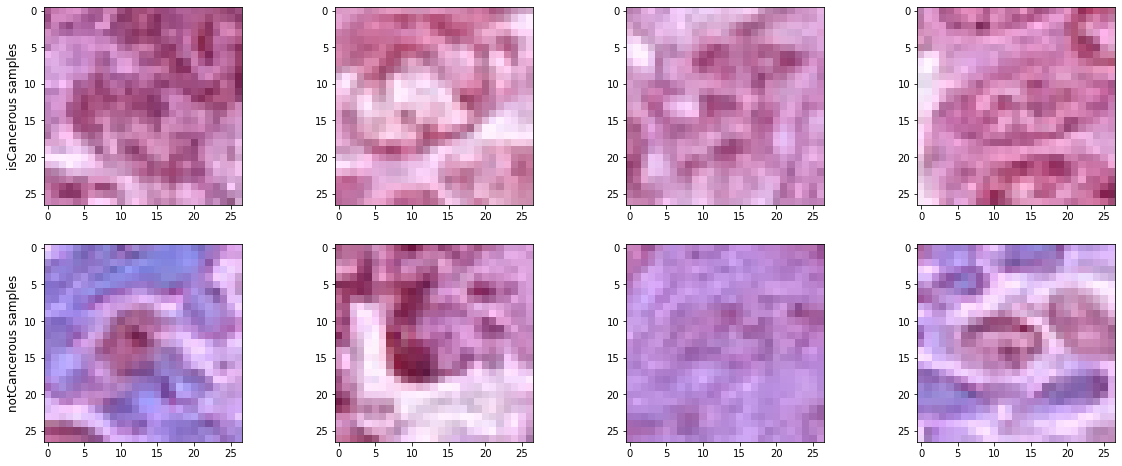

In [79]:
isCancerous = colon_main.loc[colon_main['isCancerous'] == 1].sample(4)
notCancerous = colon_main.loc[colon_main['isCancerous'] == 0].sample(4)

isCancerous_images = []
notCancerous_images = []

for path in isCancerous['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    isCancerous_images.append(image)
    
for path in notCancerous['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    notCancerous_images.append(image)

fig,axis = plt.subplots(2,4,figsize=(20,8))
for i, image in enumerate(isCancerous_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('isCancerous samples', size='large')

for i, image in enumerate(notCancerous_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('notCancerous samples', size='large')



## Function definiton to plot the accuracy

In [39]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Classic neural network model

In [38]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [82]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


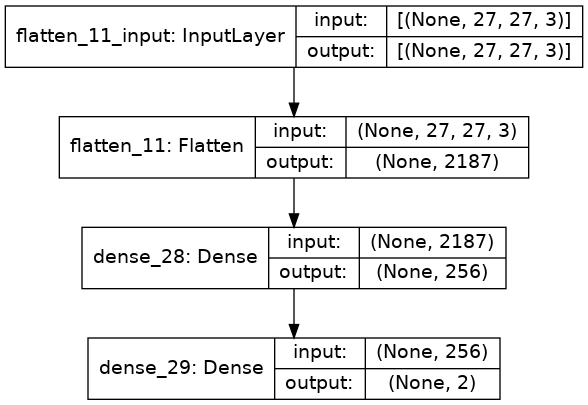

In [83]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [84]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [85]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [86]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [87]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
220/220 [==============================] - 4s 16ms/step - loss: 0.6170 - categorical_accuracy: 0.6540 - val_loss: 0.5564 - val_categorical_accuracy: 0.7009
Epoch 2/150
220/220 [==============================] - 3s 15ms/step - loss: 0.5327 - categorical_accuracy: 0.7623 - val_loss: 0.4856 - val_categorical_accuracy: 0.8009
Epoch 3/150
220/220 [==============================] - 3s 15ms/step - loss: 0.4804 - categorical_accuracy: 0.7992 - val_loss: 0.4519 - val_categorical_accuracy: 0.8408
Epoch 4/150
220/220 [==============================] - 3s 15ms/step - loss: 0.4324 - categorical_accuracy: 0.8285 - val_loss: 0.4348 - val_categorical_accuracy: 0.7761
Epoch 5/150
220/220 [==============================] - 3s 15ms/step - loss: 0.4034 - categorical_accuracy: 0.8388 - val_loss: 0.3822 - val_categorical_accuracy: 0.8378
Epoch 6/150
220/220 [==============================] - 3s 15ms/step - loss: 0.3848 - categorical_accuracy: 0.8439 - val_loss: 0.3727 - val_categorical_accuracy:

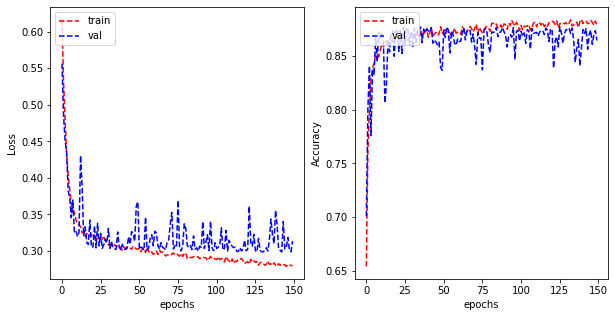

In [89]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [90]:
model.save("detect_cancer")

INFO:tensorflow:Assets written to: detect_cancer/assets


In [91]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [92]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 2ms/step - loss: 0.3206 - categorical_accuracy: 0.8697


[0.32062748074531555, 0.8696969747543335]

In [93]:
label_names = {'cancer' : 0, 'noCancer' : 1}

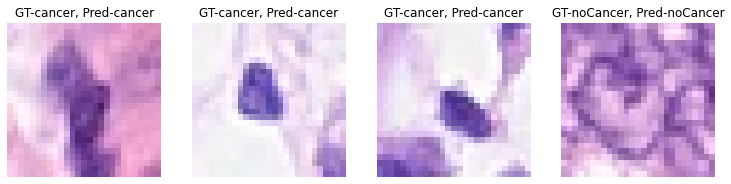

In [94]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')